In [4]:
import pandas as pd
import numpy as np

In [5]:
# 주가와 감성 데이터 합치기 (리스크:주가)
senti = pd.read_pickle('daily_sentiment.pickle')
index_ = pd.read_csv('주가지수크롤링.csv')

In [6]:
#종목명 -> 산업 통일 (KRX 제거)
index_['종목명'] = index_['종목명'].str.replace('KRX ', '', regex=False).str.strip()
# 종목명 컬럼 이름 산업으로 변경
index_ = index_.rename(columns={'종목명': 'industry'})
index_
# 날짜 포맷 변경
index_['날짜'] = pd.to_datetime(index_['날짜'], format='%Y%m%d')
index_['날짜'] = index_['날짜'].dt.strftime('%Y-%m-%d')

In [7]:
# 합치기
merged = pd.merge(senti,index_,on=['날짜','industry'],how = 'inner')

# 날짜순 정렬
merged = merged.sort_values(by=['industry', '날짜'])

In [8]:
merged.drop(columns = "Unnamed: 0")

,날짜,Ave_sentiment,본문,industry,종가(백만원),거래량(천주),전일대비
106,2025-10-01,0.696901,84,건설,773.53,6922801,5.47
107,2025-10-02,0.669425,40,건설,774.52,7349337,0.99
108,2025-10-10,0.580599,30,건설,788.26,11288559,13.74
109,2025-10-13,0.573305,50,건설,786.46,8443590,-1.80
110,2025-10-14,0.525187,71,건설,788.96,36232856,2.50
...,...,...,...,...,...,...,...
48,2025-12-15,0.803046,206,헬스케어,4927.73,30104286,62.48
49,2025-12-16,0.798630,274,헬스케어,4881.50,38287102,-46.23
50,2025-12-17,0.783878,241,헬스케어,4796.50,25323016,-85.00
51,2025-12-18,0.856880,292,헬스케어,4775.98,21146956,-20.52


In [9]:
#  리스크 지수 컬럼 추가
# 일 평균 감정 * ln(1+(산업 기사수 / 전체기사수)) * ln(1+(산업 거래량 / 전체거래량) )
# 1. 일자별 전체 합계 계산 (전체 기사수, 전체 거래량)
total_stats = merged.groupby('날짜').agg({
    '본문': 'sum',
    '거래량(천주)': 'sum'
}).rename(columns={'본문': 'Total_News', '거래량(천주)': 'Total_Volume'})

# 2. 데이터 병합
risk_data = merged.merge(total_stats, on='날짜')

# 3. 날짜 정렬
risk_data = risk_data.sort_values(by=['industry', '날짜']).reset_index(drop=True)

# 4. 리스크 지수(Risk_Index) 계산
# 분모가 0이 되는 것을 방지하기 위해 +1 처리가 된 ln(1+x) 구조 활용
## 주석_김민호) 0<x<1 의 값의 경우 x값이 0에 가까워질수록 ln(x)가 음수로 발산되어 값이 튀므로 
## 로그 내의 값을 1이상으로 만들어 시작값을 0부터 완만한 값으로 만들기 위해 사용
risk_data['Risk_Index'] = (
    risk_data['Ave_sentiment'] * np.log1p(risk_data['본문'] / risk_data['Total_News']) * np.log1p(risk_data['거래량(천주)'] / risk_data['Total_Volume'])
)

# 5. 새로운 변수로 학습 진행
features = ['Risk_Index', '종가(백만원)', 'Ave_sentiment'] # 감성지수와 리스크지수를 같이 넣어 비교
X = risk_data[features]

# 3. 'risk_data' 내부의 데이터를 사용하여 산업별 shift 수행

risk_data['D+1 종가'] = risk_data.groupby('industry')['종가(백만원)'].shift(-1)
risk_data['D+2 종가'] = risk_data.groupby('industry')['종가(백만원)'].shift(-2)

# 4. 상승률 다시 계산
risk_data['D+1 상승률'] = (risk_data['D+1 종가'] - risk_data['종가(백만원)']) / risk_data['종가(백만원)'] * 100
risk_data['D+2 상승률'] = (risk_data['D+2 종가'] - risk_data['종가(백만원)']) / risk_data['종가(백만원)'] * 100

# 5. 기사 비율
risk_data['article_ratio'] = risk_data['본문'] /risk_data['Total_News']

# 6. 거래량 비율
risk_data['trade_volum_ratio'] = risk_data['거래량(천주)'] / risk_data['Total_Volume']

risk_data.drop(columns = "Unnamed: 0")

,날짜,Ave_sentiment,본문,industry,종가(백만원),거래량(천주),전일대비,Total_News,Total_Volume,Risk_Index,D+1 종가,D+2 종가,D+1 상승률,D+2 상승률,article_ratio,trade_volum_ratio
0,2025-10-01,0.696901,84,건설,773.53,6922801,5.47,437,30751473,0.024878,774.52,788.26,0.127985,1.904257,0.192220,0.225121
1,2025-10-02,0.669425,40,건설,774.52,7349337,0.99,280,35183514,0.016957,788.26,786.46,1.774002,1.541600,0.142857,0.208886
2,2025-10-10,0.580599,30,건설,788.26,11288559,13.74,179,47060285,0.019343,786.46,788.96,-0.228351,0.088803,0.167598,0.239874
3,2025-10-13,0.573305,50,건설,786.46,8443590,-1.80,323,34617515,0.018009,788.96,822.37,0.317880,4.566030,0.154799,0.243911
4,2025-10-14,0.525187,71,건설,788.96,36232856,2.50,328,67871370,0.044022,822.37,813.93,4.234689,3.164926,0.216463,0.533846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2025-12-15,0.803046,206,헬스케어,4927.73,30104286,62.48,477,144788403,0.054455,4881.50,4796.50,-0.938160,-2.663092,0.431866,0.207919
155,2025-12-16,0.798630,274,헬스케어,4881.50,38287102,-46.23,671,139052143,0.066511,4796.50,4775.98,-1.741268,-2.161631,0.408346,0.275343
156,2025-12-17,0.783878,241,헬스케어,4796.50,25323016,-85.00,605,101148584,0.058723,4775.98,4861.55,-0.427812,1.356197,0.398347,0.250355
157,2025-12-18,0.856880,292,헬스케어,4775.98,21146956,-20.52,707,91788855,0.061420,4861.55,NaN,1.791674,NaN,0.413013,0.230387


In [10]:
risk_data.to_pickle('df_for_model.pkl',)

In [11]:
import pandas as pd
import numpy as np

n = int(input("변동성을 확인할 기준 기간(n일)을 입력하세요: "))

# 1. 원본에서 분석용 DF 생성
df_analysis = risk_data[['날짜', 'industry', 'Risk_Index']].copy()

# 2. 분석용 DF에만 계산 컬럼 추가
# groupby와 transform을 쓰되, 결과만 df_analysis에 저장
group = df_analysis.groupby('industry')['Risk_Index']

df_analysis['MA'] = group.transform(lambda x: x.rolling(window=n).mean())
df_analysis['STD'] = group.transform(lambda x: x.rolling(window=n).std())

# 3. 상/하한선 및 이상치 계산
df_analysis['Upper'] = df_analysis['MA'] + (2 * df_analysis['STD'])
df_analysis['Lower'] = df_analysis['MA'] - (2 * df_analysis['STD'])

# 4. 이상치 판별
df_analysis['Is_Outlier'] = (df_analysis['Risk_Index'] > df_analysis['Upper']) | \
                            (df_analysis['Risk_Index'] < df_analysis['Lower'])

# 5. 이상치만 모은 별도 데이터프레임
outliers = df_analysis[df_analysis['Is_Outlier'] == True].copy()

변동성을 확인할 기준 기간(n일)을 입력하세요: 90


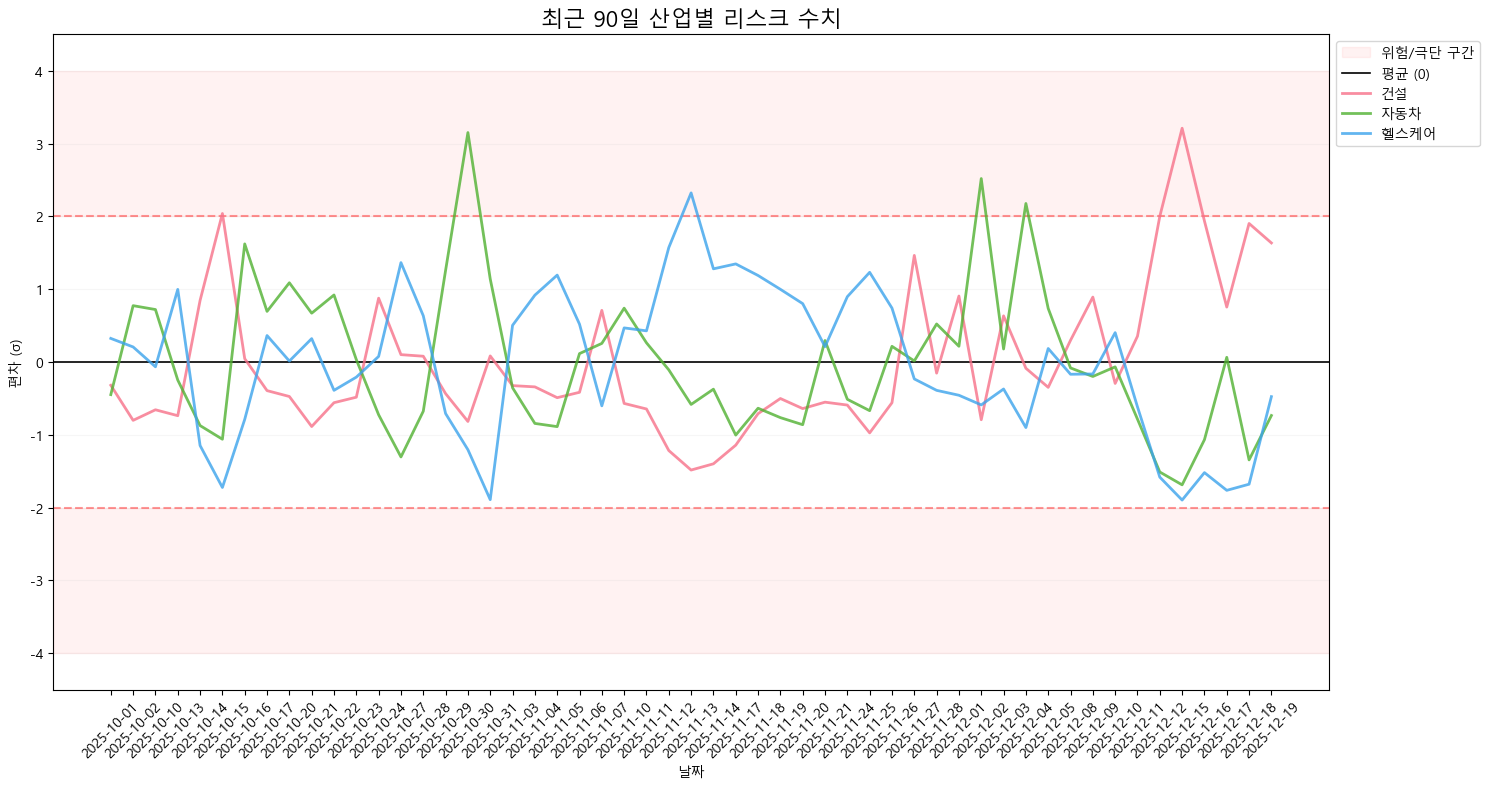

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Z-Score 계산
df_analysis['Z_Score'] = df_analysis.groupby('industry')['Risk_Index'].transform(lambda x: (x - x.mean()) / x.std())

# 1. 폰트 및 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 8))

# 2. 배경 구간 색칠
plt.axhspan(2, 4, color='red', alpha=0.05, label='위험/극단 구간')
plt.axhspan(-4, -2, color='red', alpha=0.05)

# 3. 가이드 수평선
plt.axhline(0, color='black', linewidth=1.2, label='평균 (0)')
plt.axhline(2, color='red', linestyle='--', alpha=0.4)
plt.axhline(-2, color='red', linestyle='--', alpha=0.4)

# 4. 산업별 Z-Score 선 그리기 (최신 n일치만!)
industries = df_analysis['industry'].unique()
colors = sns.color_palette("husl", len(industries))

for i, industry in enumerate(industries):
    # 해당 산업 데이터 필터링 후, 최신 n일치만 tail(n)으로 추출
    df_ind = df_analysis[df_analysis['industry'] == industry].tail(n)
    
    plt.plot(df_ind['날짜'], df_ind['Z_Score'], label=industry, color=colors[i], lw=2, alpha=0.8)

# 5. 그래프 꾸미기
plt.title(f'최근 {n}일 산업별 리스크 수치', fontsize=16)
plt.ylabel('편차 (σ)')
plt.xlabel('날짜')
plt.ylim(-4.5, 4.5)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, axis='y', alpha=0.1)

# x축 날짜 라벨이 겹치지 않게 회전 (데이터가 많을 경우 대비)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

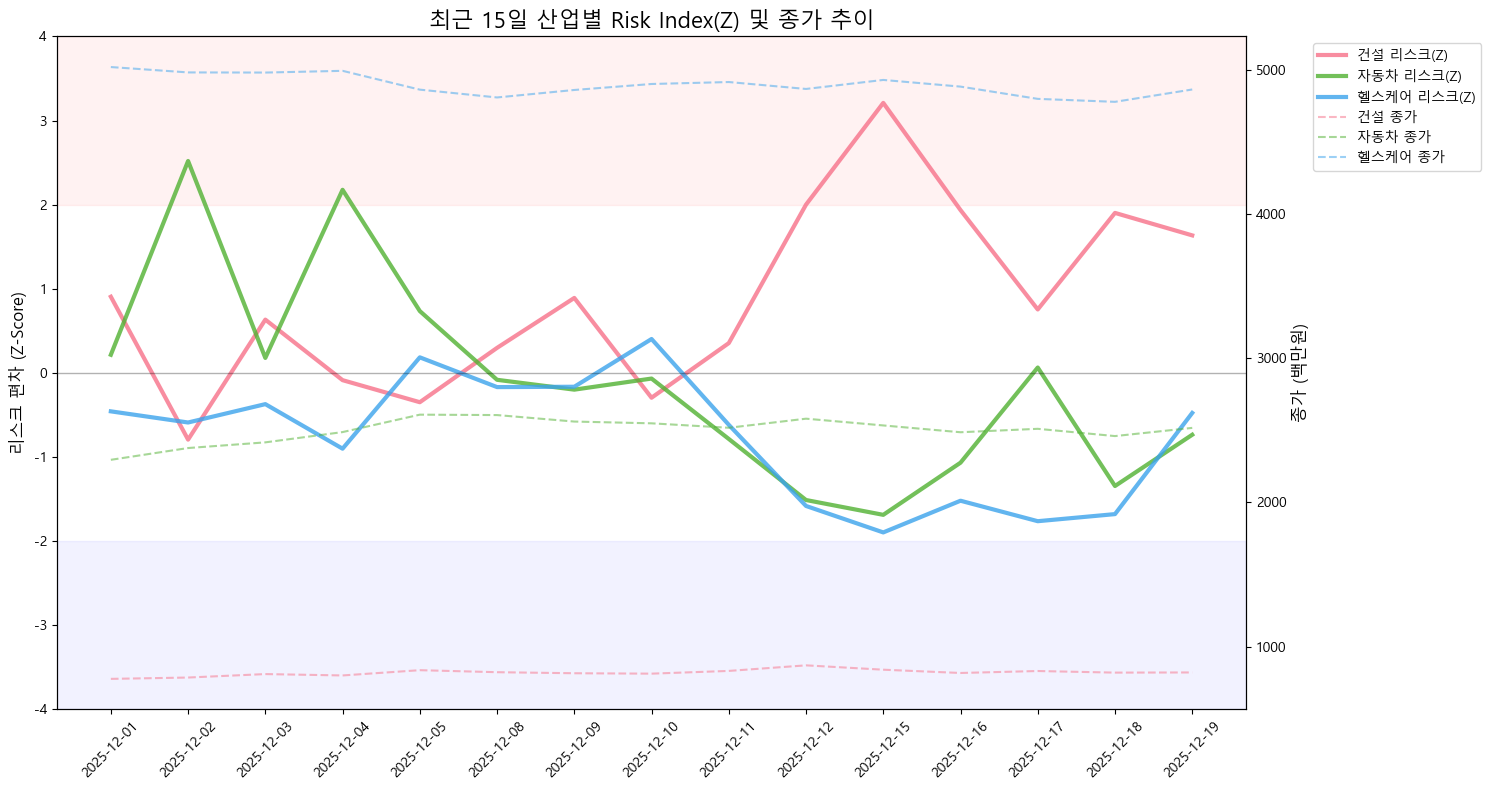

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Z-Score 계산 (risk_data 기준)
risk_data['Z_Score'] = risk_data.groupby('industry')['Risk_Index'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0
)

# 2. 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
n = 15  # 최근 15일 데이터 보기

industries = risk_data['industry'].unique()
colors = sns.color_palette("husl", len(industries))

fig, ax1 = plt.subplots(figsize=(15, 8))

# 보조 축 생성 (종가용)
ax2 = ax1.twinx()

for i, industry in enumerate(industries):
    # 해당 산업 데이터 추출
    df_ind = risk_data[risk_data['industry'] == industry].tail(n)
    
    # 왼쪽 축: Z-Score (실선)
    line1 = ax1.plot(df_ind['날짜'], df_ind['Z_Score'], label=f'{industry} 리스크(Z)', 
                     color=colors[i], lw=3, alpha=0.8)
    
    # 오른쪽 축: 종가 (점선)
    line2 = ax2.plot(df_ind['날짜'], df_ind['종가(백만원)'], label=f'{industry} 종가', 
                     color=colors[i], linestyle='--', lw=1.5, alpha=0.5)

# 3. 그래프 꾸미기
ax1.set_ylabel('리스크 편차 (Z-Score)', fontsize=12)
ax1.set_ylim(-4, 4)
ax2.set_ylabel('종가 (백만원)', fontsize=12)

# 가이드 라인 (위험 구간)
ax1.axhspan(2, 4, color='red', alpha=0.05)
ax1.axhspan(-4, -2, color='blue', alpha=0.05)
ax1.axhline(0, color='black', lw=1, alpha=0.3)

plt.title(f'최근 {n}일 산업별 Risk Index(Z) 및 종가 추이', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

# 범례 통합 표시
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

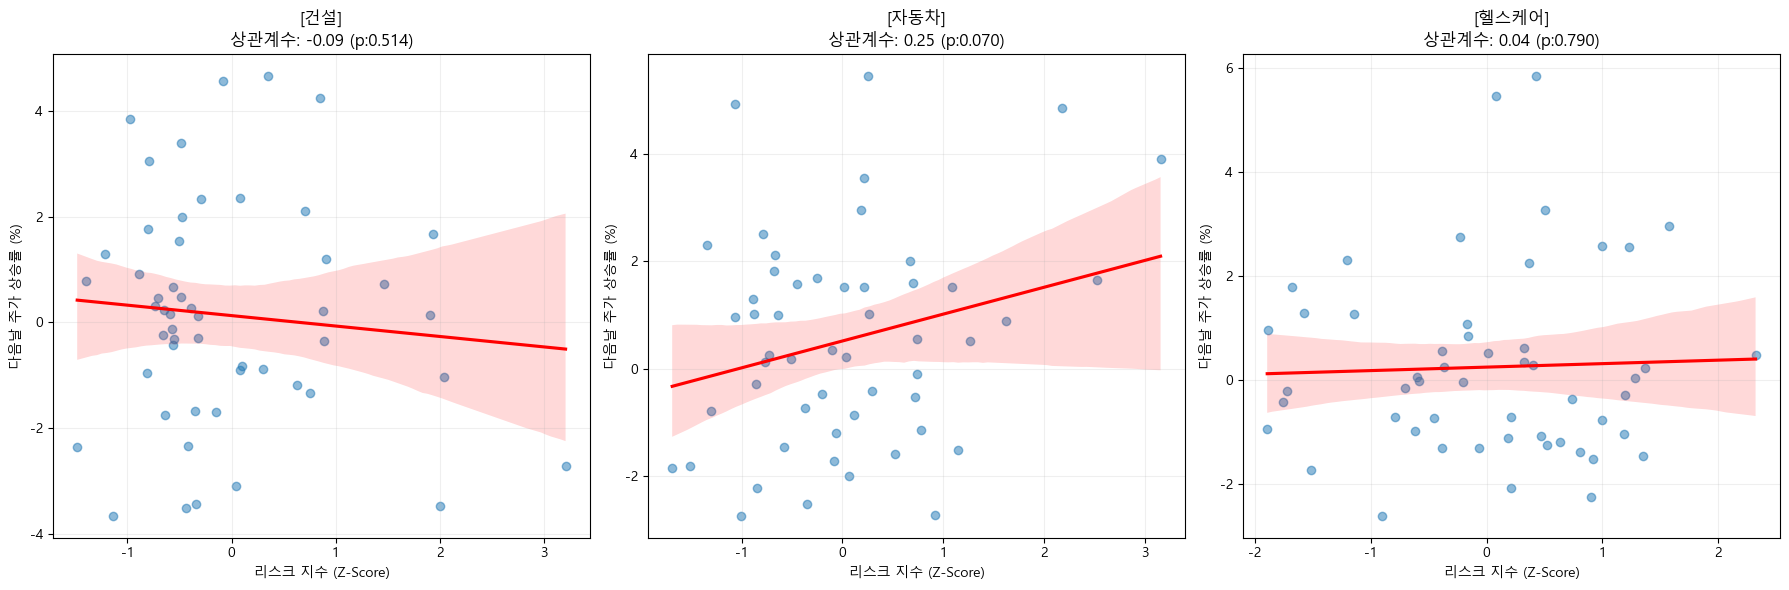

In [9]:
import scipy.stats as stats

# 1. 상관계수 계산 및 시각화
plt.figure(figsize=(18, 6))

for i, industry in enumerate(industries):
    df_ind = risk_data[risk_data['industry'] == industry].dropna(subset=['D+1 상승률', 'Z_Score'])
    
    # 상관계수(Pearson) 계산
    corr, p_value = stats.pearsonr(df_ind['Z_Score'], df_ind['D+1 상승률'])
    
    plt.subplot(1, len(industries), i+1)
    sns.regplot(data=df_ind, x='Z_Score', y='D+1 상승률', 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    plt.title(f'[{industry}]\n상관계수: {corr:.2f} (p:{p_value:.3f})')
    plt.xlabel('리스크 지수 (Z-Score)')
    plt.ylabel('다음날 주가 상승률 (%)')
    plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [ ]:
# 상관관계가 다양함 ==> 부적합?

In [23]:
df=risk_data

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# [1] 데이터 정리
df_final = df.rename(columns={'본문': 'Industry_News_Count'}).copy()

# NaN 제거 (예측 타겟인 D+1, D+2가 없는 마지막 이틀치 데이터 제외)
df_final = df_final.dropna(subset=['D+1 종가', 'D+2 종가'])

# [2] 학습 변수(X) 및 타겟(y) 설정
features = ['Ave_sentiment', 'Industry_News_Count', '종가(백만원)', '거래량(천주)', 
            '전일대비', 'Total_News', 'Total_Volume', 'Risk_Index']

X = df_final[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 정리: 컬럼명 변경 및 결측치 제거
df_model = df.rename(columns={'본문': 'Industry_News_Count'}).copy()
df_model = df_model.dropna(subset=['D+1 종가', 'D+2 종가'])

# 입력 변수(X) 및 타겟(y) 설정
features = ['Ave_sentiment', 'Industry_News_Count', '종가(백만원)', '거래량(천주)', 
            '전일대비', 'Total_News', 'Total_Volume', 'Risk_Index']

X = df_model[features].values
y_reg = df_model[['D+1 종가', 'D+2 종가']].values # 수치 예측용
y_clf = np.column_stack([
    (df_model['D+1 상승률'] > 0).astype(int), 
    (df_model['D+2 상승률'] > 0).astype(int)
]) # 상승/하락 분류용

# 데이터 스케일링 (학습 효율 극대화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터 분할 (8:2)
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)

print("✅ 전처리 완료: 학습 데이터 준비 성공")

✅ 전처리 완료: 학습 데이터 준비 성공



--- 회귀 모델 재학습 시작 (강화 버전) ---


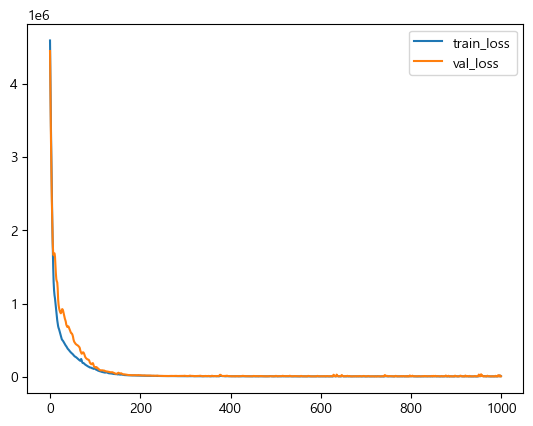

In [37]:
# 1. 에폭(Epochs)을 대폭 늘리세요 (100 -> 500~1000)
# 2. Learning Rate를 조절할 수 있는 Optimizer 설정
from tensorflow.keras.optimizers import Adam

model_reg.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

print("\n--- 회귀 모델 재학습 시작 ---")
history = model_reg.fit(X_train, y_train_reg, 
                        epochs=1000,           # 학습 횟수 10배 증가
                        validation_split=0.2,   # 검증 데이터 분리해서 모니터링
                        verbose=0)             # 너무 기니까 출력 생략

# 3. 학습 결과 시각화 (Loss가 수렴하는지 확인용)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [38]:
# 분류
model_clf = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid') # 각각 독립적인 상승 확률 출력
])

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("\n--- 분류 모델 학습 시작 ---")
model_clf.fit(X_train, y_train_clf, epochs=100, verbose=1)

# 평가
clf_loss, clf_acc = model_clf.evaluate(X_test, y_test_clf, verbose=0)

model_clf.save('stock_clf.h5')
print(f"📊 [분류 결과] Loss: {clf_loss:.4f}, 정확도(Accuracy): {clf_acc*100:.2f}%")


--- 분류 모델 학습 시작 ---
Epoch 1/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4262
Epoch 2/100
4/4 [==============================] - 0s 7ms/step - loss: 0.6870 - accuracy: 0.3770
Epoch 3/100
4/4 [==============================] - 0s 6ms/step - loss: 0.6800 - accuracy: 0.3770
Epoch 4/100
4/4 [==============================] - 0s 7ms/step - loss: 0.6753 - accuracy: 0.3443
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6712 - accuracy: 0.3033
Epoch 6/100
4/4 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.2951
Epoch 7/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6645 - accuracy: 0.3115
Epoch 8/100
4/4 [==============================] - 0s 5ms/step - loss: 0.6610 - accuracy: 0.3033
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.6578 - accuracy: 0.3279
Epoch 10/100
4/4 [==============================] - 0s 7ms/step - loss: 0.6551 - accuracy: 0.3361
Epoch 11

In [39]:
# 딥러닝
from tensorflow.keras.layers import Dropout, BatchNormalization

model_deep = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(2)
])

model_deep.compile(optimizer='adam', loss='mse', metrics=['mae'])
print("\n--- 심층 딥러닝 모델 학습 시작 ---")
model_deep.fit(X_train, y_train_reg, epochs=150, validation_data=(X_test, y_test_reg), verbose=1)

# 평가
deep_loss, deep_mae = model_deep.evaluate(X_test, y_test_reg, verbose=0)
deep_pred = model_deep.predict(X_test)
deep_r2 = r2_score(y_test_reg, deep_pred)

model_deep.save('stock_deep.h5')
print(f"📊 [딥러닝 결과] Loss: {deep_loss:.2f}, 오차(MAE): {deep_mae:.2f}원, 신뢰도(R2): {deep_r2:.4f}")


--- 심층 딥러닝 모델 학습 시작 ---
Epoch 1/150
4/4 [==============================] - 0s 33ms/step - loss: 9742619.0000 - mae: 2654.4878 - val_loss: 7766252.5000 - val_mae: 2351.5474
Epoch 2/150
4/4 [==============================] - 0s 18ms/step - loss: 9739412.0000 - mae: 2654.1179 - val_loss: 7765846.5000 - val_mae: 2351.4885
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 9736580.0000 - mae: 2653.7720 - val_loss: 7765381.5000 - val_mae: 2351.4265
Epoch 4/150
4/4 [==============================] - 0s 21ms/step - loss: 9733582.0000 - mae: 2653.4521 - val_loss: 7764851.0000 - val_mae: 2351.3574
Epoch 5/150
4/4 [==============================] - 0s 9ms/step - loss: 9730698.0000 - mae: 2653.0913 - val_loss: 7764240.5000 - val_mae: 2351.2798
Epoch 6/150
4/4 [==============================] - 0s 8ms/step - loss: 9727646.0000 - mae: 2652.7703 - val_loss: 7763539.5000 - val_mae: 2351.1941
Epoch 7/150
4/4 [==============================] - 0s 9ms/step - loss: 9724715.0000 - mae

4/4 [==============================] - 0s 9ms/step - loss: 3969194.5000 - mae: 1806.4210 - val_loss: 3494138.0000 - val_mae: 1697.7494
Epoch 112/150
4/4 [==============================] - 0s 8ms/step - loss: 3971964.0000 - mae: 1790.6530 - val_loss: 3430751.5000 - val_mae: 1683.8020
Epoch 113/150
4/4 [==============================] - 0s 8ms/step - loss: 3957003.0000 - mae: 1766.6782 - val_loss: 3374505.2500 - val_mae: 1674.1974
Epoch 114/150
4/4 [==============================] - 0s 9ms/step - loss: 3796012.0000 - mae: 1761.1805 - val_loss: 3312618.7500 - val_mae: 1661.7072
Epoch 115/150
4/4 [==============================] - 0s 8ms/step - loss: 3645909.0000 - mae: 1731.2240 - val_loss: 3257632.0000 - val_mae: 1650.9911
Epoch 116/150
4/4 [==============================] - 0s 8ms/step - loss: 3636141.5000 - mae: 1737.3104 - val_loss: 3209221.7500 - val_mae: 1639.5123
Epoch 117/150
4/4 [==============================] - 0s 8ms/step - loss: 3481126.2500 - mae: 1696.1521 - val_loss: 31448

In [40]:
from tensorflow.keras.layers import Dropout

# [모델 개선] Dropout 레이어 추가
model_clf_v2 = Sequential([
    Dense(64, activation='relu', input_shape=(len(features),)),
    Dropout(0.3),  # 30%의 노드를 무작위로 꺼서 과적합 방지
    Dense(32, activation='relu'),
    Dropout(0.2),  # 추가적인 안전장치
    Dense(2, activation='sigmoid') 
])

# 학습률을 조금 낮추어 더 세밀하게 학습하도록 설정
from tensorflow.keras.optimizers import Adam
model_clf_v2.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

print("\n--- 개선된 분류 모델 학습 시작 (Dropout 적용) ---")
# 에폭을 200으로 늘려 조금 더 충분히 학습시킵니다.
history_clf = model_clf_v2.fit(X_train, y_train_clf, 
                               epochs=200, 
                               batch_size=16, 
                               validation_data=(X_test, y_test_clf),
                               verbose=1)

# 평가
clf_loss_v2, clf_acc_v2 = model_clf_v2.evaluate(X_test, y_test_clf, verbose=0)
print(f"\n📊 [개선 결과] Loss: {clf_loss_v2:.4f}, 정확도(Accuracy): {clf_acc_v2*100:.2f}%")


--- 개선된 분류 모델 학습 시작 (Dropout 적용) ---
Epoch 1/200
8/8 [==============================] - 0s 13ms/step - loss: 0.7148 - accuracy: 0.5410 - val_loss: 0.7074 - val_accuracy: 0.5806
Epoch 2/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5082 - val_loss: 0.7089 - val_accuracy: 0.5161
Epoch 3/200
8/8 [==============================] - 0s 4ms/step - loss: 0.7077 - accuracy: 0.4672 - val_loss: 0.7100 - val_accuracy: 0.5161
Epoch 4/200
8/8 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.4508 - val_loss: 0.7113 - val_accuracy: 0.5161
Epoch 5/200
8/8 [==============================] - 0s 5ms/step - loss: 0.7062 - accuracy: 0.5328 - val_loss: 0.7111 - val_accuracy: 0.5161
Epoch 6/200
8/8 [==============================] - 0s 4ms/step - loss: 0.7094 - accuracy: 0.4754 - val_loss: 0.7118 - val_accuracy: 0.3548
Epoch 7/200
8/8 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.4180 - val_loss: 0.7136 - val_accur

8/8 [==============================] - 0s 5ms/step - loss: 0.5551 - accuracy: 0.5574 - val_loss: 0.7266 - val_accuracy: 0.3871
Epoch 118/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5835 - accuracy: 0.5000 - val_loss: 0.7361 - val_accuracy: 0.3548
Epoch 119/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5767 - accuracy: 0.4918 - val_loss: 0.7402 - val_accuracy: 0.4194
Epoch 120/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5562 - accuracy: 0.5984 - val_loss: 0.7365 - val_accuracy: 0.4516
Epoch 121/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5596 - accuracy: 0.5574 - val_loss: 0.7404 - val_accuracy: 0.3871
Epoch 122/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5456 - accuracy: 0.5656 - val_loss: 0.7404 - val_accuracy: 0.3871
Epoch 123/200
8/8 [==============================] - 0s 5ms/step - loss: 0.5592 - accuracy: 0.4754 - val_loss: 0.7390 - val_accuracy: 0.3871
Epoch 124/200
8/8 [========